#### This tutorial aims to give a detailed instruction about TCPFlow


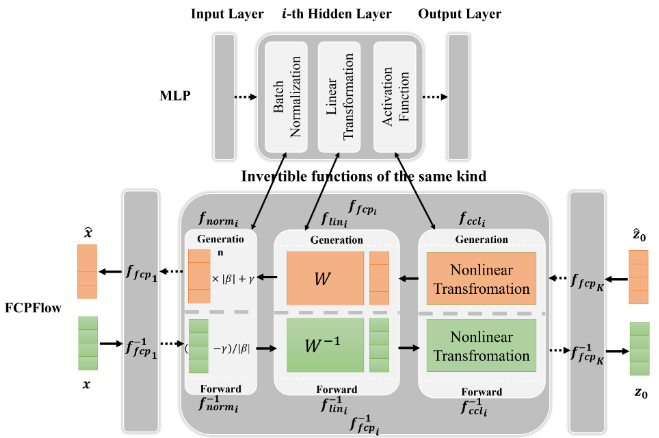

In [1]:
# import torch
import torch.nn as nn
import torch
import torch.nn.functional as F

torch.set_default_dtype(torch.float64) # set default data type

### Inveritable normalization layer

The functionality of the invertible normalization layer $f_{norm_i}$ is demonstrated. This operation is mathematically expressed as 
$$
\begin{align}
\text{Forward } f^{-1}_{norm} \quad & \mathbf{z} = \frac{\mathbf{x} - \gamma}{\sqrt{\beta^2 + \epsilon}} \\
\text{Generation }f_{norm} \quad & \mathbf{x} = \mathbf{z} \cdot \sqrt{\beta^2 + \epsilon} +\gamma
\end{align}
$$
where $\gamma$ and $\beta$ are parameters that have the same shape as $\mathbf{x}$ and $\mathbf{z}$, $\epsilon$ is a small constant ensuring numerical stability. 

To compute the log-likelihood in for FCPFlow, the log-determinant of the invertible normalization layer $f_{norm}$ is required, this is expressed as 

$$
\begin{equation}
   \log|\det\left(\frac{\partial f^{-1}_{norm}(\mathbf{x})}{\partial \mathbf{x}^\mathrm{T}}\right)| = -\log(|\prod^{T}_{i=1}(|\beta_i| + \epsilon)|)
\end{equation}
$$

where $T$ is the length of vector $\beta$, $\beta_i$ denoting the $i$-th element of vector $\beta$, for $i\in {1, 2,...,T}$. 


In [2]:
class InvertibleNorm(nn.Module):
    def __init__(self, num_channels):
        super(InvertibleNorm, self).__init__()
        self.num_channels = num_channels
        # Initialize running mean and standard deviation
        self.register_buffer('running_mean', torch.zeros(1, num_channels, 1)) # register_buffer is a function that registers a buffer as part of the module's state
        self.register_buffer('running_std', torch.ones(1, num_channels, 1)) # register_buffer is a function that registers a buffer as part of the module's state
        self.initialized = False
        self.momentum = 0.1

    def forward(self, input):
        if self.training:
            # Calculate mean and std dev for the current batch
            mean = torch.mean(input, dim=[0, 2], keepdim=True) # calculate mean
            std = torch.std(input, dim=[0, 2], keepdim=True) + 1e-10 # calculate standard deviation

            # Normalize input using calculated mean and std dev
            normalized_input = (input - mean) / std # normalize input

            # Update running statistics
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean # update running mean
            self.running_std = (1 - self.momentum) * self.running_std + self.momentum * std # update running std dev
        else:
            # Normalize input using running statistics during evaluation
            normalized_input = (input - self.running_mean) / self.running_std # normalize input

        # log-determinant of the Jacobian
        self.scale = 1 / (std + 1e-10) # calculate scale
        log_det = (
            torch.sum(torch.log(torch.abs(self.scale.squeeze() + 1e-10))) # calculate log determinant
        )
        return normalized_input, log_det

    def inverse(self, output):
        # Use running_mean and running_std for the inverse normalization
        return (output * self.running_std) + self.running_mean
    

### Inveritable linear layer

The functionality of the invertible normalization layer $f_{lin_i}$ is also demonstrated. This operation is mathematically expressed as 
$$
\begin{align}
\text{Forward } f^{-1}_{lin} \quad & \mathbf{z} = \mathbf{W^{-1}x} \\
\text{Generation }f_{lin} \quad & \mathbf{x} = \mathbf{W}\mathbf{z},
\end{align}
$$
where $\mathbf{W}$ is a invertible matrix. The invertible linear layer is an important component for enhancing the modeling capacity of the FCPFlow model. The underlying rationale for this operation lies in $\mathbf{W}$ being trained to understand the correlations among individual time steps of the RLP data. By working together with the nonlinear transformations provided by $f_{ccl}$, FCPFlow models can accurately describe the complex, high-dimensional correlations inherent in RLP data.

The log-determinants of the invertible linear layer $f_{lin}$ is expressed as
$$
\begin{equation}
    \log |\det(\frac{\mathrm{d}f^{-1}_{lin}(\mathbf{x})}{\mathrm{d}\mathbf{x^T}})|=\log |\det(\mathbf{W^{-1}})|.

\end{equation}
$$

In [3]:
class InvertibleWConv(nn.Module):
    def __init__(self, num_channels):
        super(InvertibleWConv, self).__init__()
        self.num_channels = num_channels # Length of the input vector

        # Initialize weights with a random rotation matrix
        w_init = torch.qr(torch.randn(num_channels, num_channels))[0] # QR decomposition returns a rotation matrix
        self.w = nn.Parameter(w_init) # Learnable weights

    def forward(self, input):
        out = F.conv1d(input, self.w.view(self.num_channels, self.num_channels, 1)) # Apply the weights
        log_det = torch.slogdet(self.w)[1] # Log determinant of the Jacobian, the w is $W^{-1}$ in the paper
        return out, log_det

    def inverse(self, y):
        # Compute the inverse of the weights
        w_inv = torch.inverse(self.w) # The inverse of the weights
        return F.conv1d(y, w_inv.view(self.num_channels, self.num_channels, 1))

### Combining Coupling Layer
 The forward process of combining coupling layers $f^{-1}_{ccl}$ can be expressed as 
 $$
\begin{align}
   & \mathbf{x_{1}, x_{2}}  = Split(\mathbf{x})  \\ 
   & \mathbf{(x_1, c)} = Combine(\mathbf{x_1, c}) \\
   & \mathbf{z_1} = exp(s_1(\mathbf{x_1,c})) \odot \mathbf{x_2} + t_1(\mathbf{x_1,c}) \\
   & \mathbf{(z_1, c)} = Combine(\mathbf{z_1, c}) \\
   & \mathbf{z_2} = exp(s_2(\mathbf{z_1, c})) \odot \mathbf{x_1} + t_2(\mathbf{z_1, c}) \\
   & \mathbf{z} = Combine(\mathbf{z_1, z_2})
\end{align}
$$
where $\mathbf{x}$ corresponds to the RLPs data, the operation $Split(\cdot)$ partitions the input vector$\mathbf{x}$ into two sub-vectors, $\mathbf{x_1}$ and $\mathbf{x_2}$, corresponding to the even and odd elements of $\mathbf{x}$, $s$ and $t$ are NNs, $Combine(\cdot)$ operation refers to the method used to merge two vectors into a single vector, the symbol $\odot$ indicates element-wise multiplication. The generation process of combining coupling layers $f_{ccl}$ can be expressed as
$$
\begin{align}
   & \mathbf{z_{1}, z_{2}}  = Split(\mathbf{z}) \\
   & \mathbf{(z_1, c)} = Combine(\mathbf{z_1, c}) \\
   & \mathbf{x_1} = (\mathbf{z_2} - t_2(\mathbf{z_1,c}))/ exp(s_2(\mathbf{z_1,c})) \\
   & \mathbf{(x_1, c)} = Combine(\mathbf{x_1, c}) \\
   & \mathbf{x_2} = (\mathbf{z_1} - t_1(\mathbf{x_1,c}))/ exp(s_1(\mathbf{x_1,c})) \\
   & \mathbf{x} = Combine(\mathbf{x_1, x_2}) 
\end{align}
$$
As previously discussed, to obtain the optimal set of parameters of NNs $s$ and $t$, Equation (\ref{eq6}) can be used. To do this, we need the log-determinant of $\frac{\partial f^{-1}_{ccl}(\mathbf{x;c})}{\partial \mathbf{x}^\mathrm{T}}$. The log-determinant of the $\frac{\partial f^{-1}_{ccl}(\mathbf{x;c})}{\partial \mathbf{x}^\mathrm{T}}$ can be expressed as
$$
\begin{align}
    \log|\det\left(\frac{\partial f^{-1}_{ccl}(\mathbf{x;c})}{\partial \mathbf{x}^\mathrm{T}}\right)| &= \log |\det\begin{pmatrix}
    \mathbb{I} &  \mathbf{0} \\
    * & \exp(s_2(\mathbf{z_1};c))
    \end{pmatrix}| \nonumber \\
    &\quad + \log |\det\begin{pmatrix}
    \mathbb{I} &  \mathbf{0} \\
    * & \exp(s_1(\mathbf{x_1};c))
    \end{pmatrix}|
   
\end{align}
$$
where $\mathbb{I}$ is the identity matrix, the symbol $*$ denotes the elements in the lower-left quadrant. These elements are represented by $*$ because they do not influence the value of the log-determinant being considered. 


In [4]:

class ConditionalAffineCouplingLayer(nn.Module):
    def __init__(self, net_type, sfactor, input_dim, hidden_dim, condition_dim, output_dim):
        super(ConditionalAffineCouplingLayer, self).__init__()
        self.input_dim = input_dim # Length of the input vector
        self.hidden_dim = hidden_dim # Length of the hidden vector
        self.output_dim = output_dim # Length of the output vector
        self.condition_dim = condition_dim # Length of the condition vector
        self.net_type = net_type # Type of the network， only 'fullconv' is supported
        self.sfactor = sfactor # Scaling factor

        # Conditional scale and translation networks
        self.scale_net1 = self._create_conditional_network1() # s1 NNs in the paper
        self.translate_net1 = self._create_conditional_network2() # t1 NNs in the paper
        self.scale_net2 = self._create_conditional_network1() # s2 NNs in the paper
        self.translate_net2 = self._create_conditional_network2() # t2 NNs in the paper

    def _create_conditional_network1(self):
        # Network that accepts both input and condition
        in_channel = int(self.input_dim/2)+self.condition_dim
        hidden_channel = self.hidden_dim
        out_channel = int(self.output_dim/2)
       
        if self.net_type == 'fullconv':
            return Simple1DfullConvNet(in_channel, hidden_channel, out_channel, True)
        
    def _create_conditional_network2(self):
        # Network that accepts both input and condition
        in_channel = int(self.input_dim/2)+self.condition_dim
        hidden_channel = self.hidden_dim
        out_channel = int(self.output_dim/2)
        if self.net_type == 'fullconv':
            return Simple1DfullConvNet(in_channel, hidden_channel, out_channel, True)
    
    def _positional_encoding(self, x): # Positional encoding
        length = x.shape[1]
        d_model = 1
        position = torch.arange(length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        
        # Compute the positional encoding values
        pe = torch.zeros(length, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe.reshape(1, length)
        
    def forward(self, x, condition):
        # First Affine 
        x = x + self._positional_encoding(x) # Add positional encoding
        x11 = x[:,0::2] # split the input into two part, even
        x12 = x[:,1::2] # split the input into two part, odd
        s1 = self.scale_net1(torch.cat([x11, condition], dim=1)) # s1
        s1 = torch.atan(s1/self.sfactor)*2*self.sfactor/torch.pi # smooth trick
        t1 = self.translate_net1(torch.cat([x11, condition], dim=1)) # t1
        x12_trans = x12 # redundant code :), the heritage of the previous version
        
        x12_exp = x12_trans*torch.exp(s1)+t1 # x2 = x1*exp(s1)+t1
        log_det_exp_1 = torch.sum(s1, dim=[1]) # log_det_exp_1 = sum(s1)
        x2 = torch.empty_like(x) # prepare for the output
        x2[:,0::2] = x11 
        x2[:,1::2] = x12_exp
        log_det_1 = log_det_exp_1  # redundant code :), the heritage of the previous version
        

        # Second Affine 
        x21 = x2[:,0::2] # split the input into two part, even
        x22 = x2[:,1::2] # split the input into two part, odd
        s2 = self.scale_net2(torch.cat([x22, condition], dim=1)) # s2
        s2 = torch.atan(s2/self.sfactor)*2*self.sfactor/torch.pi # smooth trick
        t2 = self.translate_net2(torch.cat([x22, condition], dim=1)) # t2
        x21_trans = x21  # redundant code :), the heritage of the previous version

        x21_exp = x21_trans*torch.exp(s2)+t2 # x1 = x2*exp(s2)+t2
        log_det_exp_2 = torch.sum(s2, dim=[1]) # log_det_exp_2 = sum(s2)
        y = torch.empty_like(x2) # prepare for the output 
        y[:,0::2] = x21_exp 
        y[:,1::2] = x22
        log_det_2 = log_det_exp_2 # redundant code :), the heritage of the previous version
    
        # Compute log-determinant
        log_det = log_det_1 + log_det_2 # log_det = log_det_1 + log_det_2

        return y, log_det.mean() 

    def inverse(self, y, condition):
        x21_exp = y[:,0::2]
        x22 = y[:,1::2]
        s2 = self.scale_net2(torch.cat([x22, condition], dim=1))
        s2 = torch.atan(s2/self.sfactor)*2*self.sfactor/torch.pi
        t2 = self.translate_net2(torch.cat([x22, condition], dim=1))
        x21_trans = (x21_exp-t2)/torch.exp(s2)
        x21 = x21_trans 
        x2 = torch.empty_like(y)
        x2[:,0::2] = x21
        x2[:,1::2] = x22
                
        x11 = x2[:,0::2]
        x12_exp = x2[:,1::2]
        s1 = self.scale_net1(torch.cat([x11, condition], dim=1)) 
        s1 = torch.atan(s1/self.sfactor)*2*self.sfactor/torch.pi
        t1 = self.translate_net1(torch.cat([x11, condition], dim=1))
        x12_trans = (x12_exp-t1)/torch.exp(s1)
        x12 = x12_trans # + sigma1
    
        x = torch.empty_like(y)
        x[:,0::2] = x11
        x[:,1::2] = x12
        
        x = x - self._positional_encoding(x)
        return x

# Define the simple 1D full convolutional network
class Simple1DfullConvNet(nn.Module):
    def __init__(self, in_c, h_c, out_c, linear = False):
        super().__init__()
        self.in_c = in_c
        self.h_c = h_c
        self.out_c = out_c
        self.linear = linear
        self.bias = True
        self.model = nn.Sequential( 
            nn.Linear(in_features=self.in_c, out_features=self.h_c, bias=self.bias),
            nn.BatchNorm1d(self.h_c),
            nn.LeakyReLU(),
            
            nn.Linear(in_features=self.h_c, out_features=self.h_c, bias=self.bias),
            nn.BatchNorm1d(self.h_c),
            nn.LeakyReLU(),
            
            nn.Linear(in_features=self.h_c, out_features=self.h_c, bias=self.bias),
            nn.BatchNorm1d(self.h_c),
            nn.LeakyReLU(),
            
            nn.Linear(in_features=self.h_c, out_features=self.h_c, bias=self.bias),
            nn.BatchNorm1d(self.h_c),
            nn.LeakyReLU(),
        )
        
        self.linear_model = nn.Linear(self.h_c, self.out_c)
        # self.leakrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        if not self.linear:
                # x = x.reshape(x.shape[0], self.in_c, 1)
                x = self.model(x)
                x = x.view(x.shape[0], -1)
                x = self.linear_model(x)
                x = self.leakrelu(x)
                return x
        else:
                # x = x.reshape(x.shape[0], self.in_c, 1)
                x = self.model(x)
                x = x.view(x.shape[0], -1)
                x = self.linear_model(x)
                return x

### FCPflow layer

In the proposed FCPFlow architecture, each transformation, denoted as $f_{fcl_i}$, is composed of three distinct components: an invertible normalization layer $f_{norm_i}$, an invertible linear layer $f_{lin_i}$, and a combining coupling layer $f_{ccl_i}$. Therefore, the operation of each transformation can be mathematically represented as a composition of these three layers: $f_{fcp_i} = f_{norm_i} \circ f_{lin_i} \circ f_{ccl_i}$.

In [5]:
class FCPflowblock(nn.Module): # Fully convolutional time Flow Block
    def __init__(self, num_channels, net_type,  sfactor, hidden_dim, condition_dim):
        super(FCPflowblock, self).__init__()
        self.num_channels = num_channels # Length of the input vector
        self.sfactor = sfactor # Scaling factor 
        self.input_dim = num_channels # Length of the input vector 
        self.hidden_dim = hidden_dim # Length of the hidden vector 
        self.output_dim = num_channels # Length of the output vector 
        self.condition_dim = condition_dim # Length of the condition vector 
        self.net_type = net_type # Type of the network 
        
        # define the layers
        self.actnorm = ChannelNorm(self.num_channels)
        self.inv_conv = InvertibleWConv(self.num_channels)
        self.coupling_layer = ConditionalAffineCouplingLayer(self.net_type, self.sfactor, self.input_dim, self.hidden_dim, self.condition_dim, self.output_dim)

    def forward(self, x, condition):
       
        x = x.unsqueeze(2)  # reshape x to (batch_size, num_channels, 1)
        
        x, log_det1 = self.actnorm(x) # noremalization
        x, log_det2 = self.inv_conv(x) # invertible 1x1 convolution
        
        # reshape x to (batch_size, num_channels)
        x = x.squeeze(2)
        x, log_det3 = self.coupling_layer(x, condition)
        
        return x,   log_det2 + log_det3 + log_det1  # + log_det4   
    
    def inverse(self, y, condition):
        x = self.coupling_layer.inverse(y, condition)
        x = x.unsqueeze(2)
        x = self.inv_conv.inverse(x)
        x = self.actnorm.inverse(x)
        x = x.squeeze(2)
        return x

### FCPFLow

 One FCPFlow model with $K$ transformations can be expressed as $F^{fcp}=f_{fcp_1}\circ f_{fcp_2}\circ...\circ f_{fcp_K}$.

 With log-determinants of $f_{lin_i}$, $f_{norm_i}$, and $f_{ccl_i}$, we can conclude the log-likelihood of FCPFlow $F^{fcl}$ of $K$ layers, which is expressed as
$$
\begin{align}
\log p_X(\mathbf{x}|\mathbf{c}) &= \log p_Z(\mathbf{z}_0) + \sum_{j=1}^{K} \bigg( \log\left|\det\left(\frac{\partial  f^{-1}_{fcl_i} (\mathbf{z_{j-1};c})}{\partial \mathbf{z_{j-1}}^\mathrm{T}}\right)\right| \bigg) \notag \\
&= \log p_Z(\mathbf{z}_0)  \notag\\ 
& + \sum_{j=1}^{K} \bigg( \log\left|\det\left(\frac{\partial  f^{-1}_{ccl_j} \circ f^{-1}_{lin_j} \circ f^{-1}_{norm_j}   (\mathbf{z_{j-1};c})}{\partial \mathbf{z_{j-1}}^\mathrm{T}}\right)\right| \bigg). \notag \\
\end{align}
 $$

In [6]:
class FCPflow(nn.Module): 
    def __init__(self, num_blocks ,num_channels, net_type, normal_type, w_type, sfactor, hidden_dim, condition_dim):
        super().__init__()
        self.num_blocks = num_blocks
        self.num_channels = num_channels
        self.net_type = net_type
        self.sfactor = sfactor
        self.input_dim = num_channels
        self.hidden_dim = hidden_dim
        self.output_dim = num_channels
        self.condition_dim = condition_dim
        self.w_type = w_type
        self.normal_type = normal_type
        
        self.blocks = nn.ModuleList([FCPflowblock(self.num_channels, self.net_type, self.normal_type, self.w_type,
                                                  self.sfactor, self.hidden_dim,
                                                  self.condition_dim) for _ in range(self.num_blocks)])
        # self.Tahhlayer = Tanhlayer()
        
    def forward(self, x, condition):
        log_det = 0
        for block in self.blocks:
            x, log_det1 = block(x, condition)
            log_det += log_det1
        # x, log_det_tahn = self.Tahhlayer(x)
        return x, log_det  # + log_det_tahn
    
    def inverse(self, y, condition):
        # y = self.Tahhlayer.inverse(y)
        for block in reversed(self.blocks):
            y = block.inverse(y, condition)
        return y

### Conditional generation using the FCPflow and USA dataset

In this section, we test the FCPFlow's performance on conditional generation. The conditions used are annual consumption and daily consumption related to each RLP.  Consequently, the FCPFlow model is formalized as $F(\mathbf{z};c_{ann},c_{daily})$.

In [7]:
# import packages and modules
import alg.tools as tl
import alg.models_fctflow_lin as fctf
import pandas as pd
import torch

C:\Users\weijiexia\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


*Load the data*

In [8]:
# load the data
path_train = r'data\usa_data_cleaned_annual_train.csv'
df_train = pd.read_csv(path_train, index_col=0)
df_train = df_train.dropna()
df_train = df_train.iloc[:100,:] # select the first 100 samples to train for this small example

paht_test = r'data\usa_data_cleaned_annual_test.csv'
df_test = pd.read_csv(paht_test, index_col=0)
df_test = df_test.dropna()
test_set =df_test.values[:30,:] # select the first 30 samples as test for this small example

*Print original load profile*

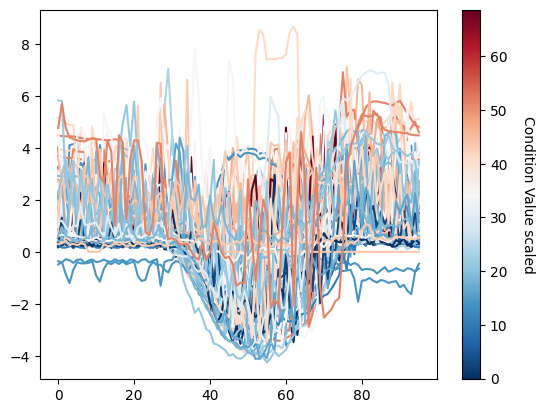

In [9]:
# create the data loader
dataLoader, scaler = tl.create_data_loader(df_train.values, batch_size=df_train.shape[0], shuffle=True) # I'm too lazy to wait, so I secretly load all the data once
data_plot = torch.tensor(scaler.transform(df_train.values[:,:]))
 # plot the real data, the y-axis is the value of the feature, the x-axis is the time, the color of profile indicates the total daily energy consumption
tl.plot_figure(data_plot , scaler, 2)

# define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

*Start model training*

c:\Users\weijiexia\OneDrive - Delft University of Technology\Align4Energy\paper2\Github\Full-Convolutional-Time-Series-Flow\alg\models_fctflow_lin.py:77: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2432.)
  w_init = torch.qr(torch.randn(num_channels, num_channels))[0]


0 loss:  95.51418675319975


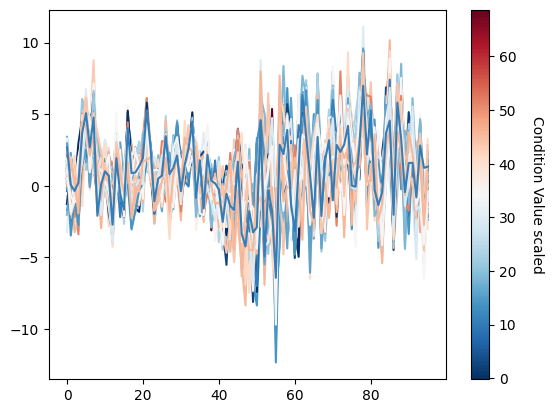

Energy distance:  0.4140465360306569 MSE.A:  0.10226243438878123
1 loss:  62.78393837558145
2 loss:  38.8070349522021
3 loss:  18.543427346526478
4 loss:  0.8729306573847708
5 loss:  -14.940872077547631
6 loss:  -29.2687267528664
7 loss:  -40.2361697963198
8 loss:  -51.93012370633735
9 loss:  -62.07534716607897
10 loss:  -71.56820737124423
11 loss:  -78.80605123841897
12 loss:  -86.4078766482987
13 loss:  -92.97599794832169
14 loss:  -99.63856509281746
15 loss:  -105.34649464314086
16 loss:  -110.93813062336031
17 loss:  -115.65574219440771
18 loss:  -120.67391506948356
19 loss:  -124.48276629354808
20 loss:  -128.61497170364822
21 loss:  -133.9568674986378
22 loss:  -135.77369268891533
23 loss:  -138.99008517493203
24 loss:  -142.68985801257367
25 loss:  -147.1829883130377
26 loss:  -150.05333525837244
27 loss:  -154.33774361930045
28 loss:  -155.4965981719463
29 loss:  -159.2342395925311
30 loss:  -162.8758819089023
31 loss:  -163.499242581232
32 loss:  -167.81286792756023
33 loss:  

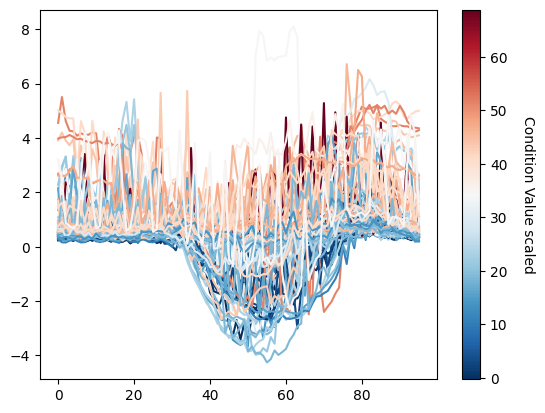

Energy distance:  0.16618260467821144 MSE.A:  0.03173448099825416
2001 loss:  -387.81488798938653
2002 loss:  -390.0825323627249
2003 loss:  -387.9677572760396
2004 loss:  -388.42026406955347
2005 loss:  -386.6959150440695
2006 loss:  -385.8371245282939
2007 loss:  -385.82836337039015
2008 loss:  -385.86572051172436
2009 loss:  -385.79422532657054
2010 loss:  -386.85850312945166
2011 loss:  -386.4292185725707
2012 loss:  -388.27434978847657
2013 loss:  -386.9757424361786
2014 loss:  -389.0441589040138
2015 loss:  -387.8162600535104
2016 loss:  -388.1516828404127
2017 loss:  -387.02795200328853
2018 loss:  -389.5187039790936
2019 loss:  -387.01661756116334
2020 loss:  -385.6519591077227
2021 loss:  -385.8242109955521
2022 loss:  -384.38152944645475
2023 loss:  -385.8729443598446
2024 loss:  -385.61089642445097
2025 loss:  -386.4398582161547
2026 loss:  -387.43488824239864
2027 loss:  -386.5072434839396
2028 loss:  -386.9865616776449
2029 loss:  -387.3729412593852
2030 loss:  -384.786240

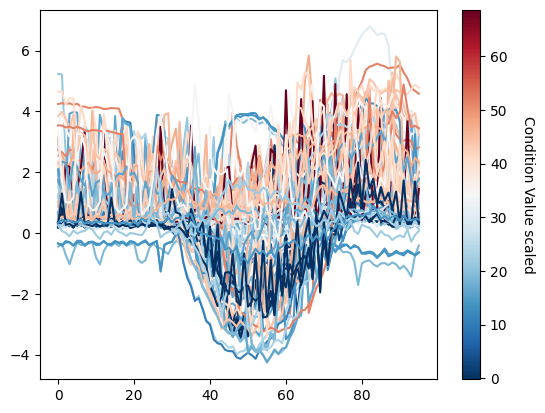

Energy distance:  0.09073643551942888 MSE.A:  0.013688895655488675
4001 loss:  -402.047809425582
4002 loss:  -401.7018579219634
4003 loss:  -403.36874905555237
4004 loss:  -399.40376275083247
4005 loss:  -401.2279531615527
4006 loss:  -400.2450033121932
4007 loss:  -402.0282301397919
4008 loss:  -402.3933052658915
4009 loss:  -402.05590941354455
4010 loss:  -404.3198198680501
4011 loss:  -402.14929647530084
4012 loss:  -401.36805127192895
4013 loss:  -401.9755304365657
4014 loss:  -399.6775380966383
4015 loss:  -399.17931002901787
4016 loss:  -400.2317753981738
4017 loss:  -398.87912122660305
4018 loss:  -397.2190022959028
4019 loss:  -397.8759217696079
4020 loss:  -399.6955056901455
4021 loss:  -400.13707415072463
4022 loss:  -399.9794338199182
4023 loss:  -399.21606200694436
4024 loss:  -397.1417003105953
4025 loss:  -397.88529704421074
4026 loss:  -400.00807553640834
4027 loss:  -399.6117768522893
4028 loss:  -399.56598764239686
4029 loss:  -399.45752932478825
4030 loss:  -401.24923

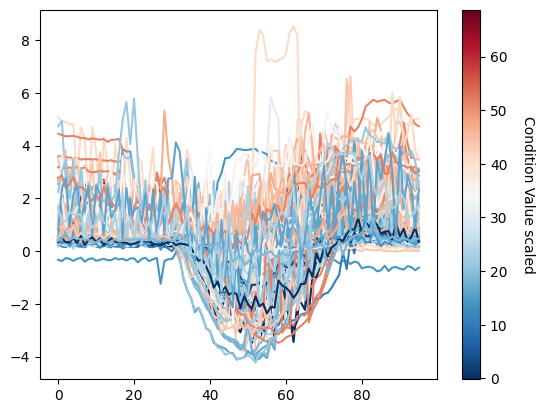

Energy distance:  0.08889335635995559 MSE.A:  0.010776313499756265
6001 loss:  -410.73503600256953
6002 loss:  -410.3695270309973
6003 loss:  -407.84826312476855
6004 loss:  -409.39039206474354
6005 loss:  -408.5723573503553
6006 loss:  -409.3191467303452
6007 loss:  -410.0487217830685
6008 loss:  -409.86566242888495
6009 loss:  -410.0647683427847
6010 loss:  -411.9591142129559
6011 loss:  -411.4712364913049
6012 loss:  -412.2842749388277
6013 loss:  -411.9321205385027
6014 loss:  -412.9447680148819
6015 loss:  -411.53323586030467
6016 loss:  -412.51576264523254
6017 loss:  -410.6301081863039
6018 loss:  -410.962261269073
6019 loss:  -410.93762392816006
6020 loss:  -408.33662342526515
6021 loss:  -408.38172477073897
6022 loss:  -409.0603472495518
6023 loss:  -409.6586835473069
6024 loss:  -408.922004046725
6025 loss:  -411.2882570390069
6026 loss:  -411.5061885464388
6027 loss:  -411.71701247437545
6028 loss:  -409.7421969310198
6029 loss:  -411.8965560599805
6030 loss:  -411.027011688

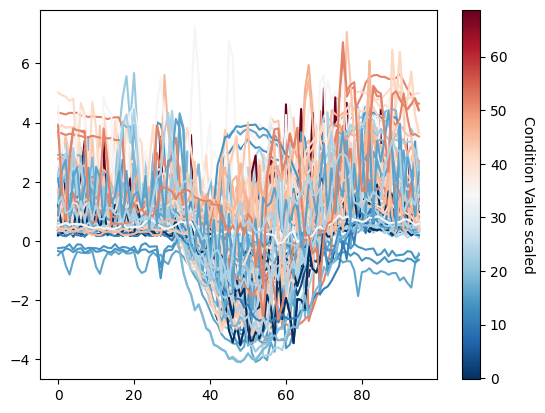

Energy distance:  0.05980253142887371 MSE.A:  0.006841134833180291
8001 loss:  -424.14259884446506
8002 loss:  -421.6564536340596
8003 loss:  -421.19063005763553
8004 loss:  -421.2735913851366
8005 loss:  -421.87266131606873
8006 loss:  -420.00044021147835
8007 loss:  -419.5418714574624
8008 loss:  -420.0707406751592
8009 loss:  -419.78246123737495
8010 loss:  -421.2447781198621
8011 loss:  -420.47256995411726
8012 loss:  -421.5952897993415
8013 loss:  -421.0920770359078
8014 loss:  -419.5226668624089
8015 loss:  -421.1181566952109
8016 loss:  -420.50530107695533
8017 loss:  -420.2436386713838
8018 loss:  -420.4202393723746
8019 loss:  -420.0641338246474
8020 loss:  -418.9602543388821
8021 loss:  -422.83146184772954
8022 loss:  -419.7174374803225
8023 loss:  -420.05514897546584
8024 loss:  -418.8606453659485
8025 loss:  -419.232297445589
8026 loss:  -421.3723382917187
8027 loss:  -418.9424839062877
8028 loss:  -418.0826983041704
8029 loss:  -419.14097806315317
8030 loss:  -418.42885791

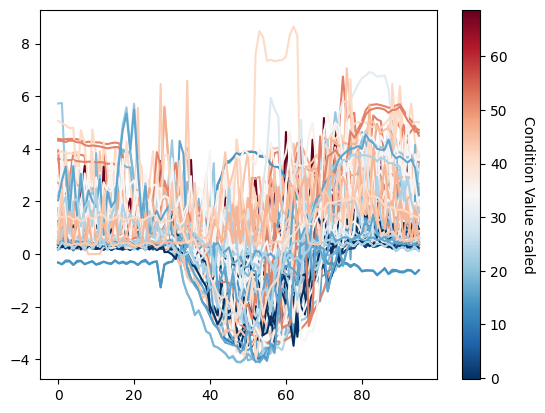

Energy distance:  0.0623918886394191 MSE.A:  0.005829052874423246
10001 loss:  -429.138346077502
10002 loss:  -429.1628522742922
10003 loss:  -426.90266053814025
10004 loss:  -423.23630790153373
10005 loss:  -418.19561118452606
10006 loss:  -420.3509632893423
10007 loss:  -422.7547006038427
10008 loss:  -423.4320005803661
10009 loss:  -423.94544194092674
10010 loss:  -425.5834792259826
10011 loss:  -426.11644645725147
10012 loss:  -427.5644303120569
10013 loss:  -428.44793704016973
10014 loss:  -428.3130963505965
10015 loss:  -427.45283369844014
10016 loss:  -427.79783576629916
10017 loss:  -428.4446644319893
10018 loss:  -426.63126418793723
10019 loss:  -428.9125354028155
10020 loss:  -427.8807113191356
10021 loss:  -429.4819989701989
10022 loss:  -428.4628944619162
10023 loss:  -429.0971373093345
10024 loss:  -429.4181486684474
10025 loss:  -428.0963202206741
10026 loss:  -429.384925602838
10027 loss:  -428.40386760343085
10028 loss:  -426.7622952618773
10029 loss:  -426.299086134100

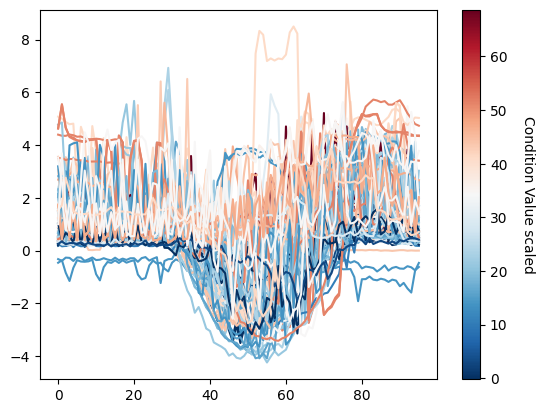

Energy distance:  0.016283838123380027 MSE.A:  0.000990768232266549
12001 loss:  -437.2167318320067
12002 loss:  -435.28783074055667
12003 loss:  -436.75618396561873
12004 loss:  -435.4701713019199
12005 loss:  -436.93760657913697
12006 loss:  -436.4684755774109
12007 loss:  -436.2905701123659
12008 loss:  -435.844487044795
12009 loss:  -436.1898439602838
12010 loss:  -437.42733858250995
12011 loss:  -436.44019195265895
12012 loss:  -436.6020261217473
12013 loss:  -436.77378364916825
12014 loss:  -436.1627491755854
12015 loss:  -436.956505731929
12016 loss:  -436.1830265965456
12017 loss:  -436.24899118735993
12018 loss:  -436.8497661435267
12019 loss:  -436.8423957226086
12020 loss:  -436.42793562523957
12021 loss:  -437.42542357089786
12022 loss:  -435.01790426047046
12023 loss:  -435.5404373297074
12024 loss:  -434.1275863780278
12025 loss:  -436.63000952050925
12026 loss:  -436.89393079163784
12027 loss:  -436.62395793051604
12028 loss:  -437.25556992496934
12029 loss:  -437.122348

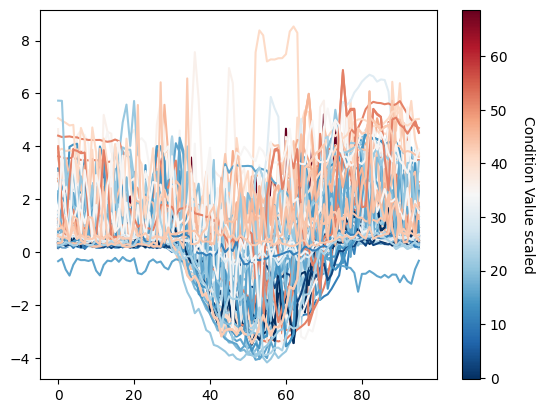

Energy distance:  0.020446294112711236 MSE.A:  0.002004428934405787
14001 loss:  -443.40768288847244
14002 loss:  -442.63063360470795
14003 loss:  -442.8741913266417
14004 loss:  -442.73817365731617
14005 loss:  -442.3116321324536
14006 loss:  -441.894729788556
14007 loss:  -442.54580817604017
14008 loss:  -441.6187036017866
14009 loss:  -440.9443375611323
14010 loss:  -442.9288658282433
14011 loss:  -440.9728076430496
14012 loss:  -441.91339670397764
14013 loss:  -444.1919484493237
14014 loss:  -442.53591958812194
14015 loss:  -440.709001160936
14016 loss:  -442.8299271471374
14017 loss:  -442.04118235523237
14018 loss:  -442.2463079245076
14019 loss:  -444.06619573351435
14020 loss:  -444.0762265387333
14021 loss:  -443.743414803105
14022 loss:  -444.06664591748796
14023 loss:  -444.2367297364245
14024 loss:  -443.6810686007649
14025 loss:  -443.8293676140821
14026 loss:  -444.3687946912179
14027 loss:  -443.6022339977271
14028 loss:  -443.7525249320697
14029 loss:  -445.088973809772

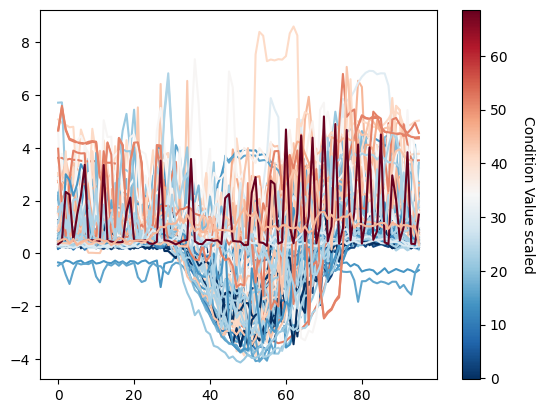

Energy distance:  0.021124279815481452 MSE.A:  0.001506165010089674
16001 loss:  -450.5263969278754
16002 loss:  -451.7368655856717
16003 loss:  -451.29439284385217
16004 loss:  -450.86866262808314
16005 loss:  -450.4769968498456
16006 loss:  -451.41219896211237
16007 loss:  -451.7186439062151
16008 loss:  -450.7054522987452
16009 loss:  -451.7732886061377
16010 loss:  -451.55205557887825
16011 loss:  -449.96629321520317
16012 loss:  -451.41938764100604
16013 loss:  -450.77765054739336
16014 loss:  -449.84241443231605
16015 loss:  -449.2550069042509
16016 loss:  -451.1004907833411
16017 loss:  -450.5759598641655
16018 loss:  -449.76298394589986
16019 loss:  -449.85114086911835
16020 loss:  -450.60595027400245
16021 loss:  -450.58916100791987
16022 loss:  -451.8972513602349
16023 loss:  -450.7190917589989
16024 loss:  -451.44088346916
16025 loss:  -450.59415682291757
16026 loss:  -450.9210809209297
16027 loss:  -450.88377412703005
16028 loss:  -453.22964976942916
16029 loss:  -451.93500

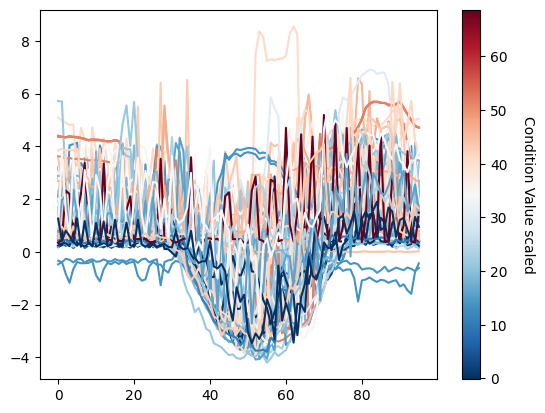

Energy distance:  0.01779384923605065 MSE.A:  0.0016207060787447995
18001 loss:  -459.2014806635185
18002 loss:  -460.47098963008546
18003 loss:  -459.86693732087616
18004 loss:  -461.0188838376034
18005 loss:  -458.841809977515
18006 loss:  -458.58361254962904
18007 loss:  -460.3545555507206
18008 loss:  -460.63576531005594
18009 loss:  -459.79934464469585
18010 loss:  -460.3445471014995
18011 loss:  -460.18423586386587
18012 loss:  -459.8981995441
18013 loss:  -461.09566037962816
18014 loss:  -460.80900376468037
18015 loss:  -460.79585575143255
18016 loss:  -459.01835518737136
18017 loss:  -460.2922398877044
18018 loss:  -459.7193421405527
18019 loss:  -460.35110233404487
18020 loss:  -461.41553585724364
18021 loss:  -459.47619405062875
18022 loss:  -460.0319092976173
18023 loss:  -459.75226803745477
18024 loss:  -460.91670639356175
18025 loss:  -461.1587298658852
18026 loss:  -460.8833539716746
18027 loss:  -459.797025527418
18028 loss:  -462.2002774388209
18029 loss:  -461.18446361

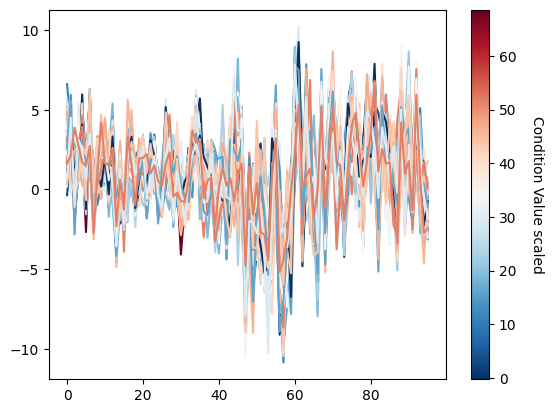

Energy distance:  0.4386295288109416 MSE.A:  0.10199836014465646
1 loss:  65.15369594756986
2 loss:  41.63932058513241
3 loss:  20.49756966001769
4 loss:  2.0626859458414657
5 loss:  -14.082291535053699
6 loss:  -28.52079979019304
7 loss:  -40.51070133724792
8 loss:  -53.22011308555986
9 loss:  -62.72526607836434
10 loss:  -71.49668362569815
11 loss:  -81.53089897414628
12 loss:  -89.36349063088342
13 loss:  -95.45708114952835
14 loss:  -101.31055714183773
15 loss:  -106.8083609293858
16 loss:  -110.44785157113122
17 loss:  -115.99232317367336
18 loss:  -119.85466171843537
19 loss:  -124.49968554351909
20 loss:  -129.7045399189839
21 loss:  -133.58551941035802
22 loss:  -138.1476220822597
23 loss:  -142.0732748623713
24 loss:  -143.95032815579444
25 loss:  -148.85175285243716
26 loss:  -151.3959380965331
27 loss:  -154.73992930757635
28 loss:  -156.9905692057944
29 loss:  -158.81709069634837
30 loss:  -162.18578502952863
31 loss:  -166.30852134101337
32 loss:  -169.06757293855972
33 lo

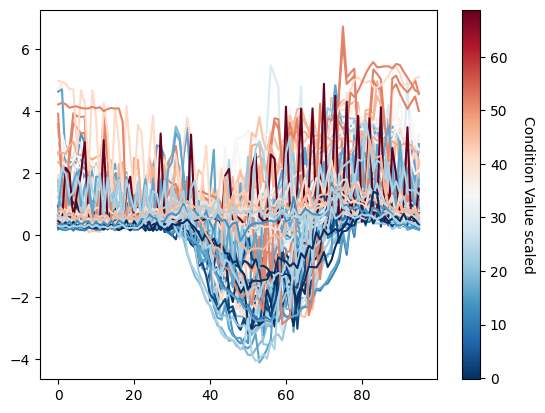

Energy distance:  0.16641161781158012 MSE.A:  0.027455341433413837
2001 loss:  -387.85881352828727
2002 loss:  -386.0518421114707
2003 loss:  -385.7658197329191
2004 loss:  -385.68045174316376
2005 loss:  -385.3556783942747
2006 loss:  -386.7017608066081
2007 loss:  -387.2876394195298
2008 loss:  -387.81925832019704
2009 loss:  -387.54529244965306
2010 loss:  -388.8087819657618
2011 loss:  -390.21701516971336
2012 loss:  -390.8885686230812
2013 loss:  -391.07063378018677
2014 loss:  -391.2866395669338
2015 loss:  -389.9304219301007
2016 loss:  -390.00150250616804
2017 loss:  -387.0064572662621
2018 loss:  -386.8084808207088
2019 loss:  -387.23834579055205
2020 loss:  -387.7168078976698
2021 loss:  -389.77309464999934
2022 loss:  -385.3637364807049
2023 loss:  -386.77130175248436
2024 loss:  -386.2386589384811
2025 loss:  -385.8001256598576
2026 loss:  -386.5478498220662
2027 loss:  -387.5605653969727
2028 loss:  -387.04902880037355
2029 loss:  -388.25487363816626
2030 loss:  -389.28272

KeyboardInterrupt: 

In [10]:
# Train the model
while True:
        
    # hyperparameters
    num_blocks = 4 # a small number of blocks for this small example, better not exceed 23 blocks due to numerical instability
    net_type = 'fullconv'  
    sfactor = 0.3 # scaling factor, 0.1 to 1 is a good range, larger value will lead to numerical instability, samller value limits the range of the output
    hidden_dim = 96*2 # hidden dimension of the s and t networks
    lr = 0.001 # check tools.oy with we defined a learning rate decay function
    w_decay = 0 # weight decay of the optimizer

    # define the model
    num_channels = 96 # resolution of the time series 
    condition_dim = 2  # annual energy consumption and daily energy consumption
    model = fctf.FCTflow(num_blocks, num_channels, net_type, sfactor, hidden_dim, condition_dim)

    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=w_decay)

    tl.train(model, dataLoader, optimizer, 20000, condition_dim, device, scaler, lr, test_set, pgap=2000)
    
    break # Opps, forgot to break the loop, in the expriment